In [5]:
import numpy as np 
import pandas as pd
from statsmodels.tsa import stattools as sts
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from fbprophet import Prophet
import matplotlib.pyplot as plt

##### Symmetric mean absolute percentage error
$SMAPE = average_i \frac{|y_i-\hat{y_i}|}{\frac{1}{2}(y_i+\hat{y_i})} \cdot 100\%.$

In [6]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [7]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title, plot_bgcolor = 'rgba(0, 0, 0, 0)',
paper_bgcolor = 'rgba(0, 0, 0, 0)')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [8]:
PATH = "../input"
train_df = pd.read_csv(f"{PATH}/train.csv", low_memory=False, 
                    parse_dates=['date'])
test_df = pd.read_csv(f"{PATH}/test.csv", low_memory=False, 
                   parse_dates=['date'])
sample_sub_df = pd.read_csv(f"{PATH}/sample_submission.csv")
display(train_df.sample(5))
display(test_df.head())

,date,store,item,sales
860805,2015-01-30,2,48,45
906988,2016-07-16,7,50,66
885372,2017-05-08,5,49,25
577690,2014-11-06,7,32,25
288796,2013-10-16,9,16,15


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [9]:
print('Entries (Train / Test) : {} / {}'.format(len(train_df), len(test_df)))
s_train, s_test = train_df.store.unique(), test_df.store.unique()
print('Stores (Train / Test) : {} - {} / {} - {}'.format(s_train[0], s_train[-1], s_test[0], s_test[-1]))
s_train, s_test = train_df.item.unique(), test_df.item.unique()
print('Items (Train / Test) : {} - {} / {} - {}'.format(s_train[0], s_train[-1], s_test[0], s_test[-1]))
dates_train, dates_test = train_df.date.unique(), test_df.date.unique()
print('Dates (Train / Test) : {:.10} - {:.10} / {:.10} - {:.10}'.format(dates_train[0], dates_train[-1], 
                                                                        dates_test[0], dates_test[-1]))
display(pd.concat([train_df.isnull().sum().rename('Training NaNs'),
                   train_df.isnull().sum().rename('Test NaNs')], axis=1))

Entries (Train / Test) : 913000 / 45000
Stores (Train / Test) : 1 - 10 / 1 - 10
Items (Train / Test) : 1 - 50 / 1 - 50
Dates (Train / Test) : 2013-01-01 - 2017-12-31 / 2018-01-01 - 2018-03-31


,Training NaNs,Test NaNs
date,0,0
store,0,0
item,0,0
sales,0,0


In [10]:
store_df = train_df.copy()
sales_pivoted_df = pd.pivot_table(store_df, index = 'store', 
                                  values=['sales','date'], columns = 'item', aggfunc = np.mean)
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [11]:
sales_store_data = go.Scatter(
    x = np.arange(1,11),
    y = sales_across_store_df.avg_sale.values,
    marker = dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.avg_sale.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize=True,
    title = 'Scatter plot of avg sales per store',
    hovermode = 'closest',
    xaxis = dict(
        title = 'Stores',
        ticklen = 10,
        zeroline = False,
        gridwidth = 1
    ),
    yaxis = dict(
        title = 'Avg Sales',
        ticklen = 10,
        zeroline = False,
        gridwidth = 1
    ),
    width=1600,
    height=300,
    margin=dict(l=20, r=20, t=40, b=20),    
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(size=16)
#     plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(data = data, layout = sales_store_layout)
py.iplot(fig, filename='scatter_sales_store')

In [12]:
sales_across_item_df = sales_pivoted_df.copy()
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r:r.mean(), axis =0)
display(sales_across_item_df)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   
11     21.981599  58.574151  36.642223  22.010241  18.358708  58.503888   

                                                   ...                        \
item          7          8          9          10  ...         41         42   
store                                              ...                         
1      52.783680  69.472070  46.504929  66.354326  ...  20.002738  33.105696   
2      75.058598  99.090361  65.478094  94.097481  ...  28.069551  47.368018   
3      66.647864  87.517525  58.486857  83.387733  ...  24.989047  41.797371   
4      61.625411  80.819825  54.043812  77.047645  ...  23.168127  38.539978   
5      44.535597  58.565717  38.837349  55.509858  ...  16.830778  27.730559   
6      44.599124  58.385542  39.460022  55.565170  ...  16.607338  27.893209   
7      40.709748  53.723987  35.901972  51.156627  ...  15.471522  25.435926   
8      71.730559  94.461117  63.193319  89.818182  ...  27.036145  45.144031   
9      61.812158  81.287514  54.105696  77.105148  ...  23.191128  38.643483   
10     65.807777  86.176889  57.886637  82.232202  ...  24.654984  41.222892   
11     58.531051  76.950055  51.389869  73.227437  ...  22.002136  36.688116   

                                                                          \
item          43         44          45         46         47         48   
store                                                                      
1      46.242607  26.594195   72.720701  52.845016  19.814348  46.546002   
2      65.785323  37.785871  103.381161  75.219606  28.187842  66.028478   
3      58.197700  33.386090   91.851041  66.748083  25.120482  58.700986   
4      54.018620  30.952355   84.687295  61.420044  23.114458  53.765608   
5      39.163198  22.415115   61.427163  44.734940  16.699343  39.281490   
6      39.034502  22.322563   61.142935  44.539978  16.708653  39.052574   
7      35.426068  20.446331   55.905805  40.828587  15.479189  35.624315   
8      62.980285  36.194414   98.941402  72.004929  27.150055  62.737130   
9      54.152793  30.968237   85.093647  62.010953  23.003286  53.976999   
10     57.942497  32.916758   90.690581  66.046550  24.755750  57.814896   
11     51.294359  29.398193   80.584173  58.639869  22.003341  51.352848   

                             
item          49         50  
store                        
1      26.461665  59.342826  
2      37.711939  84.622125  
3      33.259584  74.958379  
4      30.840635  68.921687  
5      22.371851  50.319277  
6      22.181271  50.516429  
7      20.406353  45.823658  
8      36.035049  80.972070  
9      31.052574  69.308324  
10     33.032311  74.037240  
11     29.335323  65.882202  

[11 rows x 50 columns]

In [13]:
avg_sales_per_item_across_stores_df = pd.DataFrame(
    data = [[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])],
    columns = ['item', 'avg_sale']
)
avg_sales_per_item_across_stores_df.sort_values(by = 'avg_sale', ascending =False, inplace = True)

In [14]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
sales_item_data = go.Bar(
    x = np.arange(0,50),
    y = avg_sales_per_item_across_stores_sorted,
    marker = dict(
        color = avg_sales_per_item_across_stores_sorted,
        colorscale = 'Blackbody',
        showscale = True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    width=1600,
    height=500,
    margin=dict(l=20, r=20, t=40, b=20),    
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(size=16),
    showlegend= False
)

fig = go.Figure(data = data, layout = sales_item_layout)
py.iplot(fig,filename = 'scatter_sales_item')

fig.write_image(file = "../images/Sales_by_item.png", width = 1600, height = 500)

In [15]:
store_item_df = train_df.copy()
store_id = 1
item_id = 10
store_item_df = store_item_df[(store_item_df.store == store_id)&(store_item_df.item == item_id)]

# display(store_item_df)
store_item_ts_data = [go.Scatter(
    x = store_item_df.date,
    y = store_item_df.sales
)]


example_layout = go.Layout(
    autosize= True,
    title= 'Sales of 10th item in 1st store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Date',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    width=1600,
    height=300,
    margin=dict(l=20, r=20, t=40, b=20),    
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(size=16),
    showlegend= False
)

fig = go.Figure(data = store_item_ts_data, layout = example_layout)
py.iplot(fig)

In [34]:
plotly_df(pd.DataFrame(sts.periodogram(store_item_df.sales)))
# with plt.style.context('seaborn-white'):   
#     plt.figure(figsize=(11, 3))
#     plt.plot(pd.DataFrame(sts.periodogram(store_item_df.sales)))
#     plt.legend(loc="best")
#     plt.axis('tight')
#     plt.grid(True)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:986: FutureWarning:

periodogram is deprecated and will be removed after 0.11. Use scipy.signal.periodogram instead.



In [17]:
print('1-st season period : %.8f' %(len(store_item_df.sales)/5))
print('2-nd season period : %.8f' %(len(store_item_df.sales)/261))
print('3-rd season period : %.8f' %(len(store_item_df.sales)/522))

1-st season period : 365.20000000
2-nd season period : 6.99616858
3-rd season period : 3.49808429


In [18]:
multi_store_item_df = train_df.copy()
multi_store_id = np.arange(1,6)
multi_item_id = np.ones(5)*10
multi_store_item_ts_data = []
multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(multi_store_id)&multi_store_item_df.item.isin(multi_item_id)]
# display(multi_store_item_df)
for st, i in zip(multi_store_id, multi_item_id):
    flt = multi_store_item_df[(multi_store_item_df.store == st)&(multi_store_item_df.item == i)][-730:]
    multi_store_item_ts_data.append(go.Scatter(x = flt.date, y = flt.sales.rolling(10, win_type='triang').sum(), 
                                              name = "Store:" + str(st) + ",Item:" + str(i)))

multy_store_layout = go.Layout(
    autosize= True,
    title= 'Two years of sales',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Date',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=40, b=20),    
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(size=16),
    showlegend= False
)

fig = go.Figure(data = multi_store_item_ts_data, layout = multy_store_layout)
py.iplot(fig)
fig.write_image(file = "../images/Two_years_multiple_sales_example.png", width = 400, height = 500)

### Тройное экспоненциальное сглаживание методом Хольта-Винтерса

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$


$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



SMAPE Error Score: 17.13 %


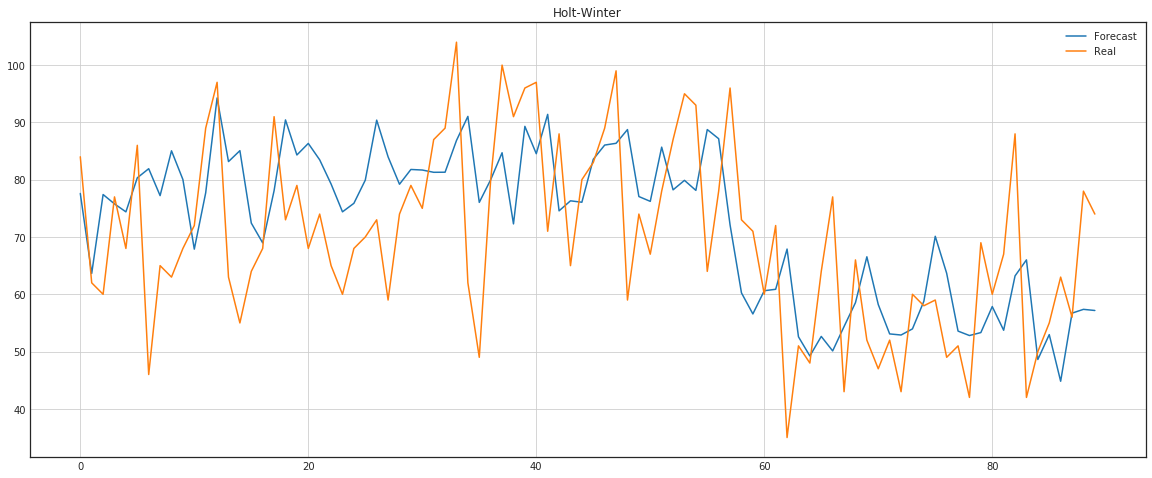

In [19]:
# Передаем оптимальные значения модели, 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
data = store_item_df.sales
model = ExponentialSmoothing(data[:-90], 
                                  seasonal_periods=365,
                                  trend='mul', 
                                  seasonal='add').fit()
fcast_ts = model.forecast(90)

with plt.style.context('seaborn-white'):   
    
    plt.figure(figsize=(20, 8))
    plt.plot(np.array(fcast_ts), label = 'Forecast')
    plt.plot(np.array(data[-90:]), label = 'Real')
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Holt-Winter")
    plt.grid(True)
SMAPE(np.array(fcast_ts), np.array(data[-90:]))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarnin

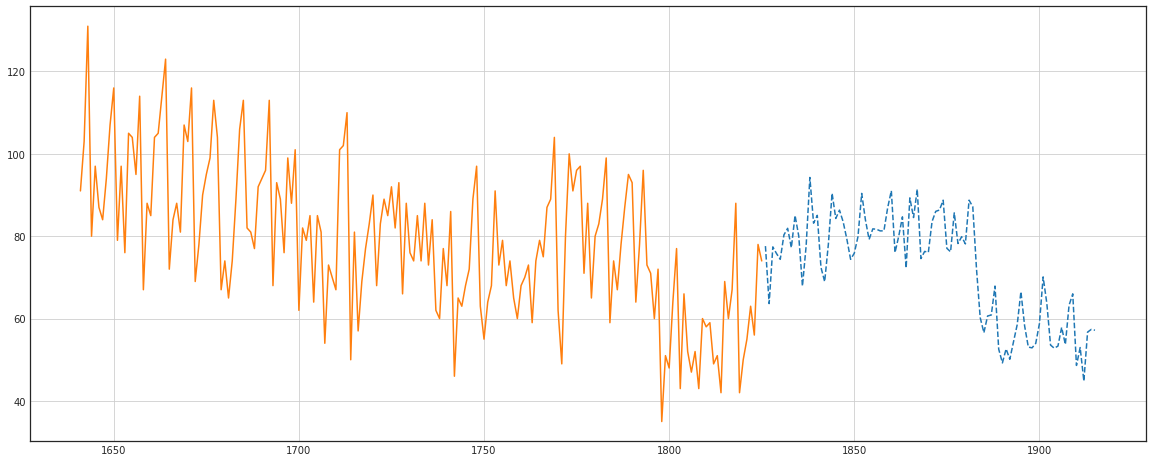

In [35]:
# Для презентации, 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
data = store_item_df.sales

model1 = ExponentialSmoothing(data, 
                                  seasonal_periods=365,
                                  trend='mul', 
                                  seasonal='add').fit()
fcast_ts1 = model1.forecast(90)
model1 = ExponentialSmoothing(data, 
                                  seasonal_periods=365,
                                  trend='mul', 
                                  seasonal='add').fit()
fcast_ts1 = model1.forecast(90)
index = np.arange(len(data)+90)
with plt.style.context('seaborn-white'):   
    
    plt.figure(figsize=(20, 8))
    plt.plot(index[-90:],np.array(fcast_ts), label = 'Forecast', linestyle='dashed' )
    plt.plot(index[-275:-90], np.array(data)[-185:], label = 'Real')
    plt.axis('tight')
#     plt.title("Holt-Winter")
    plt.grid(True)
# SMAPE(np.array(fcast_ts), np.array(data[-90:]))

Эконометрический подход

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

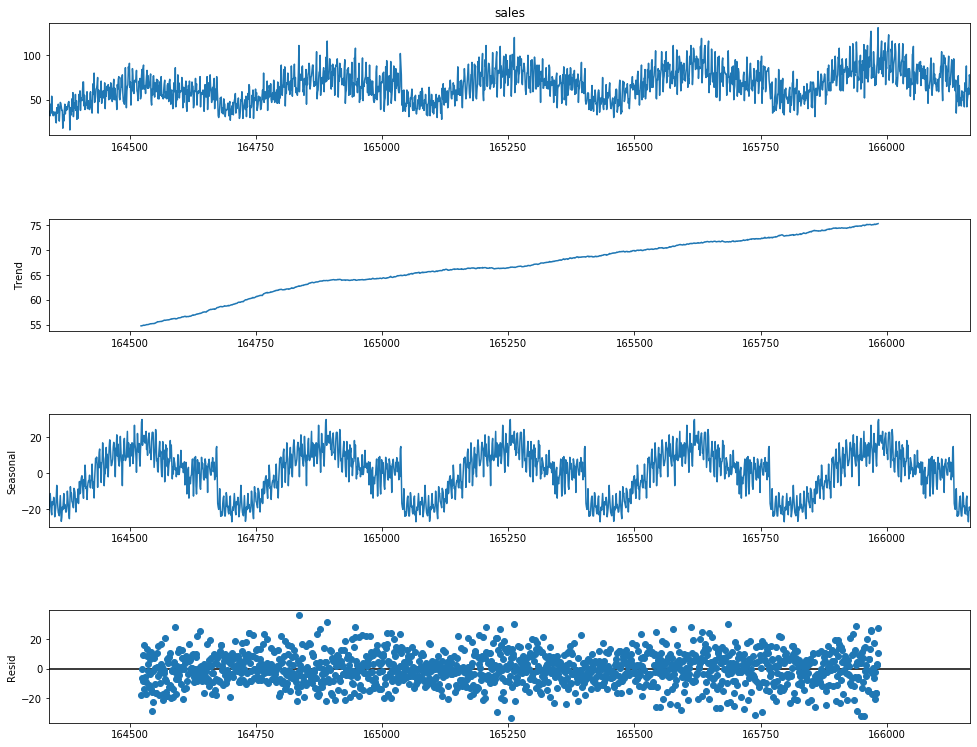

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive', freq = 365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,12)


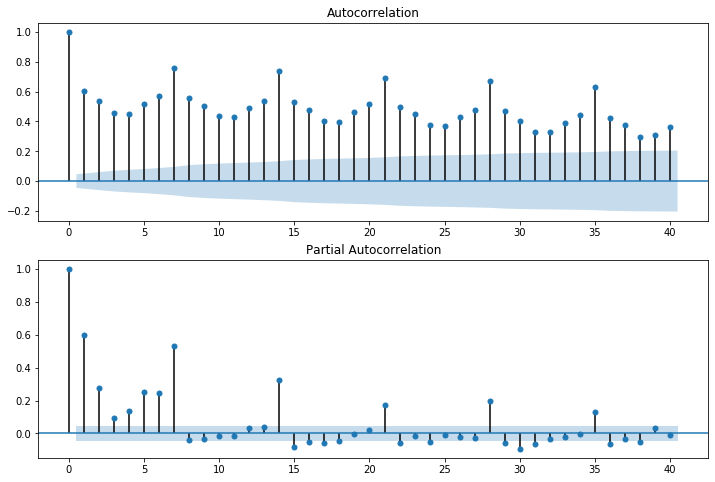

In [22]:
import statsmodels.api as sm
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags = 40, ax = ax2)

In [23]:
# prepare Fourier terms
from pmdarima import auto_arima

train_df_2 = pd.read_csv(f"{PATH}/train.csv", low_memory=False, 
                    parse_dates=['date'], index_col=['date'])

sample_train_df = train_df_2[(train_df_2['store'] == 1) & (train_df_2['item'] == 10)] # item 1 in store 1

y = sample_train_df['sales']

y_to_train = y.iloc[:(len(y)-365)]
y_to_test = y.iloc[(len(y)-365):] 

exog = pd.DataFrame({'date': y.index})

exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:(len(y)-365)]
exog_to_test = exog.iloc[(len(y)-365):] 

# Fit model
arima_exog_model = auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=365, exogenous=exog_to_test)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA

KeyboardInterrupt: 

In [ ]:
SMAPE(y_arima_exog_forecast,y_to_test)

In [ ]:

train_df = pd.read_csv(f"{PATH}/train.csv", low_memory=False, 
                    parse_dates=['date'])

def separate_forecast(i_num, s_num):
    df = train_df.query('store == @s_num & item == @i_num')[['date', 'sales']]
    df.columns = ['ds', 'y']
    
    m = Prophet()
    m.fit(df[:-90])
    future = m.make_future_dataframe(periods = 90)
    ts_hat = m.predict(future).merge(df[['ds', 'y']], on='ds', how='left')
#     display(ts_hat.tail(5))
    
    data = []
    data.append(go.Scatter(
        x = ts_hat.ds,
        y = ts_hat.y,
        name = 'real'
    ))
    data.append(go.Scatter(
        x = ts_hat.ds,
        y = ts_hat.yhat,
        name = 'forecast'
    ))
    py.iplot(data)
    SMAPE(ts_hat.y,ts_hat.yhat)
separate_forecast(1, 1)

Решение следуя логике 

In [ ]:
# def dumb_prediction(train, test, submission):
#     for _, row in test.iterrows():
#         item, store = row['item'], row['store']
#         day, month = row.name.day, row.name.month
#         itemandstore = (train.item == item) & (train.store == store)
#         dayandmonth = (train.index.month == month) & (train.index.day == day)
#         train_rows = train.loc[itemandstore & dayandmonth]
#         pred_sales = int(round(train_rows.mean()['sales']))
#         submission.at[row['id'], 'sales'] = pred_sales
#     return submission

# sub = dumb_prediction(train, test, sample_sub)
# sub.to_csv('submission.csv', index = False)

In [ ]:
PATH = "../input"
train_df = pd.read_csv(f"{PATH}/train.csv", low_memory=False, 
                    parse_dates=['date'], index_col=['date'])
test_df = pd.read_csv(f"{PATH}/test.csv", low_memory=False, 
                   parse_dates=['date'], index_col=['date'])
sample_sub_df = pd.read_csv(f"{PATH}/sample_submission.csv")

def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    return data

data = expand_df(train_df)
display(data)

grand_avg = data.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

In [ ]:
agg_year_item = pd.pivot_table(data, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(data, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item )
plt.title("Items")
plt.xlabel("Year")
plt.subplot(122)
plt.plot(agg_year_store)
plt.title("Stores")
plt.xlabel("Year")
plt.show()

In [ ]:

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

In [ ]:
agg_month_item = pd.pivot_table(data, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(data, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

In [ ]:
agg_dow_item = pd.pivot_table(data, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(data, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

In [ ]:
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Monthly pattern
month_table = pd.pivot_table(data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of week pattern
dow_table = pd.pivot_table(data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Yearly growth pattern
year_table = pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

print(f"2018 Relative Sales by Degree-1 (Linear) Fit = {p1(2018):.4f}")
print(f"2018 Relative Sales by Degree-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annual_growth = p2

In [ ]:
%%time
def slightly_better(test, submission):
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.name.dayofweek, row.name.month, row.name.year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        pred_sales = base_sales * mul * annual_growth(year)
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

slightly_better_pred = slightly_better(test_df, sample_sub_df.copy())
slightly_better_pred.to_csv("sbp_float.csv", index=False)

sbp_round = slightly_better_pred.copy()
sbp_round['sales'] = np.round(sbp_round['sales']).astype(int)
# sbp_round.to_csv("sbp_round.csv", index=False)